<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Leonardo_Pacheco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [5]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

from math import ceil

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.batch_size = batch_size
        if shuffle:
            self.dataset = dataset[torch.randperm(len(dataset))]
        else:
            self.dataset = dataset
        self.batch_number = ceil(len(self.dataset) / self.batch_size)

    def __len__(self):
        return self.batch_number
    
    def __iter__(self):
        self.dataset_index = 0
        return self

    def __next__(self):
        batch_size = self.batch_size
        if batch_size + self.dataset_index > len(self.dataset):
            batch_size = len(self.dataset) - self.dataset_index
            if self.dataset_index >= len(self.dataset):
                raise StopIteration
        for batch_index in range(batch_size):
            data, target = self.dataset[batch_index + self.dataset_index]
            if batch_index == 0:
                batch_data = data
                batch_targets = torch.tensor([target])
            else:
                batch_data = torch.cat((batch_data, data))
                batch_targets = torch.cat((batch_targets, torch.tensor([target])))
        self.dataset_index += batch_size
        return batch_data, batch_targets

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [7]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [8]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

import torch

class Model():
    def __init__(self, input, output):
        self.weight = torch.zeros((input, output), requires_grad=True)
        self.bias = torch.zeros((1, output), requires_grad=True)

    def print_parameters(self):
        print('Weights -', self.weight, self.weight.shape)
        print('Biases -', self.bias, self.bias.shape)
        print()
    
    def forward(self, x):
        return x @ self.weight + self.bias

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        return [self.weight, self.bias]


In [9]:
model = Model(28*28, 10)
model.print_parameters()

Weights - tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True) torch.Size([784, 10])
Biases - tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True) torch.Size([1, 10])



## Treinamento

### Inicialização dos parâmetros

In [10]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [11]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss() = LogSoftmax o NLLLoss.

from torch import Tensor
#from torch.nn.functional import softmax

class CrossEntropyLoss():
    def __init__(self):
        self.loss_value = None

    def one_hot(self, target, nclasses):
        if isinstance(target, Tensor):
            rows = target.shape[0]
        else:
            rows = 1
        onehot = torch.zeros((rows, nclasses))  #onehot matrix initially with only zeros
        row_numbers = np.arange(rows)           #array of row_numbers of onehot matrix, each element is row_number corresponding to each element of y
        onehot[row_numbers, target] = int(1.)   #for each element of y, row index is the order of element (registered in array row_numbers), column
        return onehot

    def softmax(self, logits):
        elogits = logits.exp()
        return elogits / elogits.sum(dim=1, keepdims=True)
        
    def __call__(self, logits, target):
        logSoftmax = self.softmax(logits).log()
        onehot = self.one_hot(target, logits.shape[1])
        class_loss = -onehot * logSoftmax
        element_loss = class_loss.sum(dim=1)
        self.loss_value = element_loss.mean(dim=0)
        return self.loss_value

criterion = CrossEntropyLoss()


# Definição do Optimizer

In [12]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
    def __init__(self, parameters, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        for param in self.parameters:
            param.data -= self.learning_rate * param.grad

    def zero_grad(self):
        for param in self.parameters:
            param.grad = torch.zeros_like(param.data)

optimizer = SGD(model.parameters(), lr)

### Laço de treinamento dos parâmetros

In [13]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786017417908
Epoch: 3/49 Loss: 0.6381281614303589
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.4786270558834076
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.43632185459136963
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.4039044976234436
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799142360687
Epoch: 14/49 Loss: 0.3662314713001251
Epoch: 15/49 Loss: 0.35566139221191406
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.32807353138923645
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123182952404022
Epoch: 21/49 Loss: 0.30506113171577454
Epoch: 22/49 Loss: 0.29816243052482605
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.28531038761138916
Epoch: 25/49 Loss: 0.27930301427841187
Epoch: 26/4

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

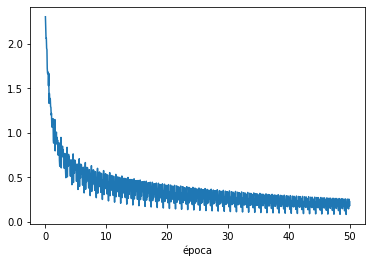

In [14]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

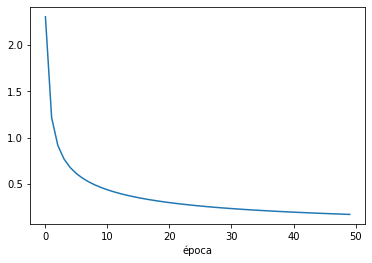

In [15]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [16]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

  2 x 2 (0.9999897) 	     2 x 2 (0.3353268) 	        3 x 8 (0.8530497) 	   5 x 8 (0.3353268)


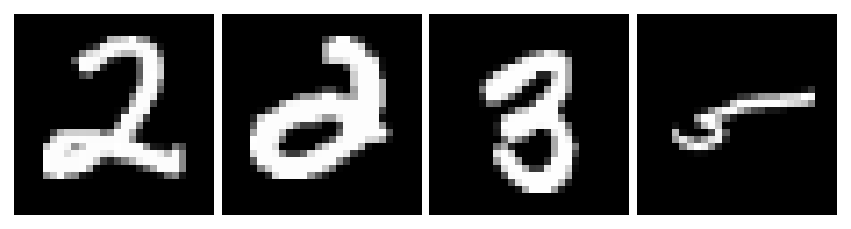

In [17]:
result = {'x':{}, 'y':{}, 'y_pred':{}}
result['prob'] = {'ok_maior': 0, 'nok_maior': 0, 'ok_menor': 1, 'nok_menor': 1}

with torch.no_grad():
    for x,y in dataset_train:
        input = x.view(-1, 28 * 28)
        probs = criterion.softmax(model(input))
        argmax = probs.argmax().item()
        maxprob = probs.tolist()[0][argmax]
        if argmax == y: 
            if maxprob > result['prob']['ok_maior']:
                result['prob']['ok_maior'] = maxprob
                result['x']['ok_maior'] = x
                result['y']['ok_maior'] = y
                result['y_pred']['ok_maior'] = argmax
            if maxprob < result['prob']['ok_menor']:
                result['prob']['ok_menor'] = maxprob
                result['x']['ok_menor'] = x
                result['y']['ok_menor'] = y
                result['y_pred']['ok_menor'] = argmax
        else: 
            if maxprob > result['prob']['nok_maior']:
                result['prob']['nok_maior'] = maxprob
                result['x']['nok_maior'] = x
                result['y']['nok_maior'] = y
                result['y_pred']['nok_maior'] = argmax
            if maxprob < result['prob']['nok_menor']:
                result['prob']['nok_menor'] = maxprob
                result['x']['nok_menor'] = x
                result['y']['nok_menor'] = y
                result['y_pred']['nok_menor'] = argmax
    print(' ', result['y']['ok_maior'], 'x', result['y_pred']['ok_maior'], '(' + str(round(result['prob']['ok_maior'], 7)) + ')', '\t    ', 
          result['y']['ok_menor'], 'x', result['y_pred']['ok_menor'], '(' + str(round(result['prob']['ok_menor'], 7)) + ')', '\t       ', 
          result['y']['nok_maior'], 'x', result['y_pred']['nok_maior'], '(' + str(round(result['prob']['nok_maior'], 7)) + ')', '\t  ', 
          result['y']['nok_menor'], 'x', result['y_pred']['nok_menor'], '(' + str(round(result['prob']['ok_menor'], 7)) + ')')

    grid = torchvision.utils.make_grid([result['x']['ok_maior'], result['x']['ok_menor'], result['x']['nok_maior'], result['x']['nok_menor']], pad_value=1.0, padding=1)

    plt.figure(figsize=(15, 10))
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    plt.axis('off')


## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.


In [113]:
#implementação meio ingenua, nao funciona 100% no caso de quantidades não inteiras em cada classe e passa muitas vezes em alguns elementos do DataSet

class BalancedDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, balance = None):
        super().__init__(dataset, batch_size, shuffle)
        if balance:
            self.balance = np.array(balance)
            assert self.balance.sum() == 1
            self.sizes = self.balance * batch_size
            self.classes = len(balance)
        else:
            self.balance = self.sizes = self.classes = None

    def __iter__(self):
        self.last_index = np.zeros(self.classes) - 1
        return super().__iter__()

    def __next__(self):
        if self.balance is None:
            return super().__next__()
        actual_index = int(self.last_index.min()) + 1
        used = np.zeros(self.classes)
        batch_index = 0
        while batch_index < self.batch_size:
            data, target = self.dataset[actual_index]
            #print('debug>', actual_index, batch_index, target, used, self.sizes)
            if used[target] < self.sizes[target] and actual_index > self.last_index[target]:
                if batch_index == 0:
                    batch_data = data
                    batch_targets = torch.tensor([target])
                else:
                    batch_data = torch.cat((batch_data, data))
                    batch_targets = torch.cat((batch_targets, torch.tensor([target])))
                used[target] += 1
                self.last_index[target] = actual_index
                batch_index += 1
            actual_index += 1
            if actual_index >= len(self.dataset):
                raise StopIteration
        return batch_data, batch_targets

indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)
balanced_loader_train = BalancedDataLoader(dataset_train, batch_size=batch_size, shuffle=False, balance = [0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [114]:
print('distribuicao:', balanced_loader_train.balance, '->', balanced_loader_train.balance.sum())
print('quantidades:', balanced_loader_train.sizes,  '->',  balanced_loader_train.sizes.sum())
print('classes:', balanced_loader_train.classes)

distribuicao: [0.01 0.01 0.72 0.2  0.01 0.01 0.01 0.01 0.01 0.01] -> 1.0
quantidades: [ 0.5  0.5 36.  10.   0.5  0.5  0.5  0.5  0.5  0.5] -> 50.0
classes: 10


In [118]:
for i, (x_train, y_train) in enumerate(balanced_loader_train):
    ys = y_train.numpy()
    assert sum(ys == 2) == 32
    assert sum(ys != 2) == 18
    print(str(i) + ':', ys)
print('last index for each class:', balanced_loader_train.last_index)    

0: [4 8 2 0 1 3 9 6 3 3 7 5 3 2 3 3 2 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
1: [1 8 4 9 0 5 7 6 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
last index for each class: [ 20.  15. 978. 336.  17.  28.  38.  34.  10.  19.]
